In [2]:
import scanpy as sc
from scipy.sparse import csc_matrix, csr_matrix, save_npz
from scipy.io import mmread, mmwrite
import numpy as np
import pandas as pd
from pathlib import Path
from os import path
import seaborn as sns

In [104]:
folder = '/gpfs/gibbs/pi/zhao/yw599/Multiome/data/MouseAtlas' 
atac_anno = pd.read_csv('%s/ATAC/cell_metadata.tissue_freq_filtered_lung.txt' % folder, index_col=0)
rna_anno = pd.read_csv('%s/RNA/annotations_droplet_lung.csv' % folder, index_col=0)

In [70]:
count1 = sc.read_10x_mtx('%s/RNA/droplet/Lung-10X_P7_8' % folder)
count1.obs_names = ['10X_P7_8_' + n.split('-')[0] for n in count1.obs_names]

In [71]:
count2 = sc.read_10x_mtx('%s/RNA/droplet/Lung-10X_P7_9' % folder)
count2.obs_names = ['10X_P7_9_' + n.split('-')[0] for n in count2.obs_names]

In [72]:
count3 = sc.read_10x_mtx('%s/RNA/droplet/Lung-10X_P8_12' % folder)
count3.obs_names = ['10X_P8_12_' + n.split('-')[0] for n in count3.obs_names]

In [73]:
count4 = sc.read_10x_mtx('%s/RNA/droplet/Lung-10X_P8_13' % folder)
count4.obs_names = ['10X_P8_13_' + n.split('-')[0] for n in count4.obs_names]

In [106]:
adata_rna = sc.concat([count1, count2, count3, count4])
adata_rna = adata_rna[rna_anno.cell].copy()
rna_anno.set_index('cell', inplace=True)
adata_rna.obs = rna_anno

In [14]:
count = mmread('%s/ATAC/activity_scores.quantitative.mtx.gz' % folder)
adata_ga = sc.AnnData(count.transpose().tocsr())
# del count
adata_ga.obs_names = pd.read_table('%s/ATAC/activity_scores.quantitative.cells.txt' % folder, header = None)[0].tolist()
adata_ga.var_names = pd.read_table('%s/ATAC/activity_scores.quantitative.genes.txt' % folder, header = None)[0].tolist()
adata_ga = adata_ga[atac_anno.cell].copy()
atac_anno.set_index('cell', inplace=True)
adata_ga.obs = atac_anno

In [108]:
def simMatrix(adata, normalize=True, log=True, hvgs=2000, npcs=30, cell_type='annotation'):
    if normalize:
        sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    if log:
        sc.pp.log1p(adata)
    if hvgs:
        sc.pp.highly_variable_genes(adata, n_top_genes=hvgs)
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pl.pca_variance_ratio(adata, log=True)
    sc.pp.neighbors(adata, n_pcs=npcs)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=[cell_type], legend_loc='on data')
    sc.tl.paga(adata, groups=cell_type)
    sc.pl.paga(adata, color=[cell_type])
    pos = adata.uns['paga']['pos']
    D = np.zeros((pos.shape[0], pos.shape[0]))
    for i in range(D.shape[0]-1):
        for j in range(i+1,D.shape[0]):
            D[i,j] = (((pos[i,]-pos[j,])**2).sum())**.5
    D = D+D.transpose()
    ct = adata.obs[cell_type].cat.categories.tolist()
    sim = pd.DataFrame(np.exp(-D), index=ct, columns=ct)
    return sim

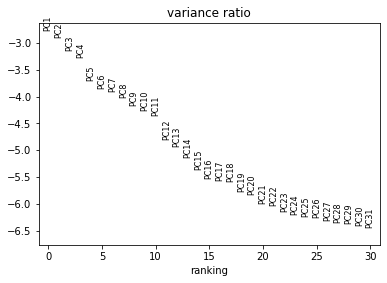

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_ontology_class' as categorical
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_ontology_id' as categorical
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be r

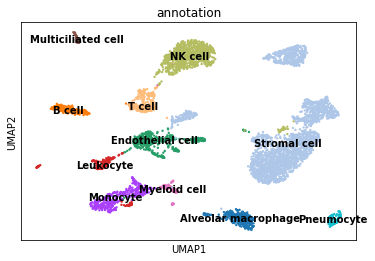

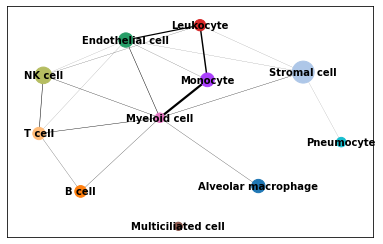

In [109]:
sim_rna = simMatrix(adata_rna)

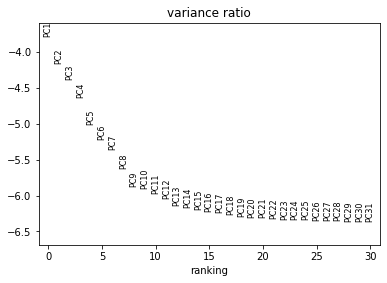

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tissue' as categorical
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tissue.replicate' as categorical
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a f

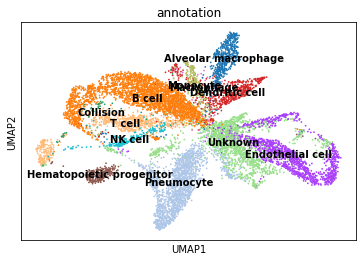

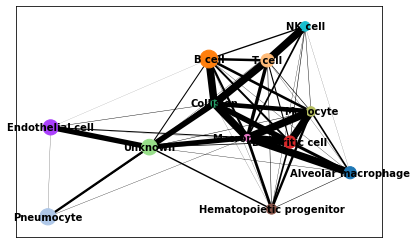

In [66]:
sim_atac = simMatrix(adata_ga)

In [110]:
sim_rna

,Alveolar macrophage,B cell,Endothelial cell,Leukocyte,Monocyte,Multiciliated cell,Myeloid cell,NK cell,Pneumocyte,Stromal cell,T cell
Alveolar macrophage,1.000000,0.073167,0.020984,0.022921,0.078835,0.224583,0.118997,0.017452,0.206273,0.068113,0.032027
B cell,0.073167,1.000000,0.029480,0.015205,0.042481,0.193381,0.128983,0.066561,0.018451,0.014130,0.232370
Endothelial cell,0.020984,0.029480,1.000000,0.319207,0.222102,0.013196,0.157962,0.232982,0.019594,0.066684,0.082998
Leukocyte,0.022921,0.015205,0.319207,1.000000,0.285266,0.009959,0.111167,0.076327,0.033909,0.156060,0.032527
Monocyte,0.078835,0.042481,0.222102,0.285266,1.000000,0.034198,0.328717,0.089528,0.088200,0.241835,0.063124
Multiciliated cell,0.224583,0.193381,0.013196,0.009959,0.034198,1.000000,0.082332,0.018663,0.046336,0.018789,0.052335
Myeloid cell,0.118997,0.128983,0.157962,0.111167,0.328717,0.082332,1.000000,0.139715,0.065690,0.095305,0.163058
NK cell,0.017452,0.066561,0.232982,0.076327,0.089528,0.018663,0.139715,1.000000,0.009691,0.021924,0.264323
Pneumocyte,0.206273,0.018451,0.019594,0.033909,0.088200,0.046336,0.065690,0.009691,1.000000,0.183577,0.011712
Stromal cell,0.068113,0.014130,0.066684,0.156060,0.241835,0.018789,0.095305,0.021924,0.183577,1.000000,0.016087


In [67]:
sim_atac

,Alveolar macrophage,B cell,Collision,Dendritic cell,Endothelial cell,Hematopoietic progenitor,Macrophage,Monocyte,NK cell,Pneumocyte,T cell,Unknown
Alveolar macrophage,1.000000,0.093663,0.152178,0.433597,0.029652,0.346665,0.272887,0.356403,0.102936,0.028854,0.142484,0.095854
B cell,0.093663,1.000000,0.508054,0.209211,0.122962,0.092376,0.280872,0.242191,0.297006,0.048669,0.509085,0.223422
Collision,0.152178,0.508054,1.000000,0.350967,0.146737,0.177886,0.526850,0.326234,0.208331,0.076514,0.408106,0.369355
Dendritic cell,0.433597,0.209211,0.350967,1.000000,0.062997,0.355063,0.609423,0.592456,0.172292,0.049392,0.283010,0.197972
Endothelial cell,0.029652,0.122962,0.146737,0.062997,1.000000,0.059054,0.103287,0.049355,0.036653,0.258396,0.067492,0.308341
Hematopoietic progenitor,0.346665,0.092376,0.177886,0.355063,0.059054,1.000000,0.327891,0.213208,0.061392,0.075826,0.105403,0.184420
Macrophage,0.272887,0.280872,0.526850,0.609423,0.103287,0.327891,1.000000,0.433818,0.163390,0.075071,0.303254,0.321145
Monocyte,0.356403,0.242191,0.326234,0.592456,0.049355,0.213208,0.433818,1.000000,0.275849,0.032570,0.398327,0.144000
NK cell,0.102936,0.297006,0.208331,0.172292,0.036653,0.061392,0.163390,0.275849,1.000000,0.016036,0.510224,0.077272
Pneumocyte,0.028854,0.048669,0.076514,0.049392,0.258396,0.075826,0.075071,0.032570,0.016036,1.000000,0.031307,0.207147


<AxesSubplot:>

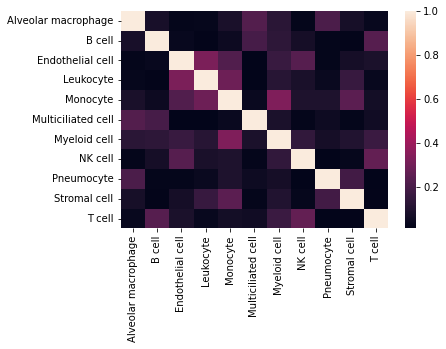

In [112]:
sns.heatmap(sim_rna)

<AxesSubplot:>

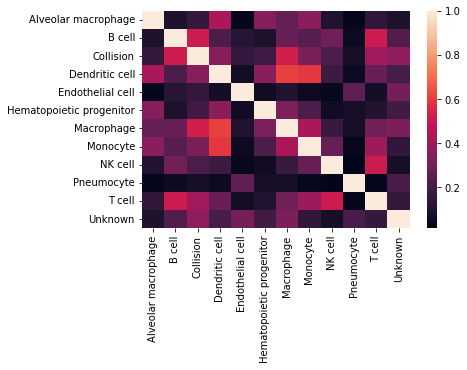

In [113]:
sns.heatmap(sim_atac)

In [117]:
def crossOmicSimMatrix(sim_rna, sim_atac):
    
    ct_rna = sim_rna.index.tolist()
    ct_atac = sim_atac.index.tolist()

    # common cell types
    ct_common = list(set(ct_rna).intersection(ct_atac))

    # rna unique cell types
    ct_rna_only = list(set(ct_rna).difference(ct_atac))

    # atac unique cell types
    ct_atac_only = list(set(ct_atac).difference(ct_rna))
    
    sim = np.zeros((len(ct_atac), len(ct_rna)))
    
    # common to common
    sim[:len(ct_common), :len(ct_common)] = (sim_rna.loc[ct_common, ct_common] + sim_atac.loc[ct_common, ct_common])/2
    
    # atac unique to common
    sim[len(ct_common):, :len(ct_common)] = sim_atac.loc[ct_atac_only, ct_common]
    
    # common to rna unique
    sim[:len(ct_common), len(ct_common):] = sim_rna.loc[ct_common, ct_rna_only]
    
    # atac unique to rna unique
    temp1 = sim_atac.loc[ct_atac_only, ct_common]
    temp1[temp1 < 0.5] = 0
    temp2 = sim_rna.loc[ct_common, ct_rna_only]
    denom = (temp1 != 0).sum(1).values.reshape((-1,1))
    sim[len(ct_common):, len(ct_common):] = (temp1.values @ temp2.values) / denom
    
    sim = pd.DataFrame(sim, index = ct_common + ct_atac_only, columns =  ct_common + ct_rna_only).fillna(0)
    
    return sim

In [118]:
sim = crossOmicSimMatrix(sim_rna, sim_atac)

/tmp/ipykernel_27655/3746516461.py:31: RuntimeWarning: invalid value encountered in true_divide
  sim[len(ct_common):, len(ct_common):] = (temp1.values @ temp2.values) / denom


In [119]:
sim

,NK cell,B cell,Pneumocyte,T cell,Monocyte,Endothelial cell,Alveolar macrophage,Myeloid cell,Leukocyte,Multiciliated cell,Stromal cell
NK cell,1.000000,0.181784,0.012863,0.387273,0.182688,0.134818,0.060194,0.139715,0.076327,0.018663,0.021924
B cell,0.181784,1.000000,0.033560,0.370728,0.142336,0.076221,0.083415,0.128983,0.015205,0.193381,0.014130
Pneumocyte,0.012863,0.033560,1.000000,0.021509,0.060385,0.138995,0.117564,0.065690,0.033909,0.046336,0.183577
T cell,0.387273,0.370728,0.021509,1.000000,0.230726,0.075245,0.087255,0.163058,0.032527,0.052335,0.016087
Monocyte,0.182688,0.142336,0.060385,0.230726,1.000000,0.135728,0.217619,0.328717,0.285266,0.034198,0.241835
Endothelial cell,0.134818,0.076221,0.138995,0.075245,0.135728,1.000000,0.025318,0.157962,0.319207,0.013196,0.066684
Alveolar macrophage,0.060194,0.083415,0.117564,0.087255,0.217619,0.025318,1.000000,0.118997,0.022921,0.224583,0.068113
Dendritic cell,0.172292,0.209211,0.049392,0.283010,0.592456,0.062997,0.433597,0.194750,0.169007,0.020261,0.143277
Unknown,0.077272,0.223422,0.207147,0.151060,0.144000,0.308341,0.095854,0.000000,0.000000,0.000000,0.000000
Hematopoietic progenitor,0.061392,0.092376,0.075826,0.105403,0.213208,0.059054,0.346665,0.000000,0.000000,0.000000,0.000000


<AxesSubplot:>

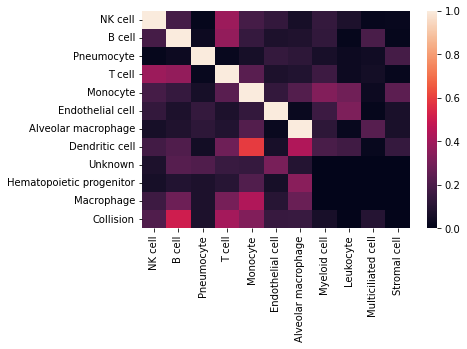

In [120]:
sns.heatmap(sim)

In [123]:
# save
sim.to_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/data/MouseAtlas/sim_lung.csv')